In [1]:
from pathlib import Path
from io import BytesIO

import wbgapi as wb
import pandas as pd
import requests_cache
import docx
import matplotlib.pyplot as plt
import seaborn as sns
from docx.oxml.ns import qn

requests_cache.install_cache("wbgapi")
sns.set(style="white")
font = {"family": "Songti SC", "size": "10.5"}
plt.figure(figsize=(6.4, 4.8))
plt.rc("font", **font)
plt.rc("axes", unicode_minus=False)
flatui = ["#DF7A5E", "#F0C986", "#82B29A", "#3C405B"]
flatui_2 = ["#DF7A5E", "#3C405B"]
common_tick_params = dict(
    direction="in",
    length=4,
    width=1.5,
    colors="black",
    grid_color="black",
    grid_alpha=0.5,
)

route = Path.home() / "OneDrive" / "Rawdata"

years = list(range(2005, 2021))
time_period = f"{years[0]}-{years[-1]}"
countrycode = pd.read_excel(
    route / "Country Code" / "Countrycode.xlsx",
    sheet_name="Sheet1",
    na_values="..",
)
df_final = pd.read_csv(route / "Data Cleaning" / "df_final.csv").drop(columns=["Alpha-3 code"]).merge(countrycode, on="Numeric").set_index(["Alpha-3 code", "Year"])
africa_region = {"E": "东部非洲", "W": "西部非洲", "S": "南部非洲", "C": "中部非洲"}
abbreviation = {"SSA": "撒哈拉以南非洲", "LMY": "中低收入国家", "HIC": "高收入国家", "WLD": "全球"}
abbreviation_2 = {"SSA": "撒哈拉以南非洲", "LMY": "中低收入国家", "HIC": "高收入国家", "OWID_WRL": "全球"}
wdi = pd.read_csv(
    route / "World Bank World Development Index" / "WDI_csv" / "WDIData.csv",
    na_values="..",
).drop(columns=["Unnamed: 67"])
df_world = (
    wdi.drop(columns=["Country Name", "Indicator Code"])
    .rename(columns={"Country Code": "Alpha-3 code"})
    .query(
        '`Alpha-3 code` == "WLD" | `Alpha-3 code` == "SSA" | `Alpha-3 code` == "LMY" | `Alpha-3 code` == "HIC"'
    )
    .melt(id_vars=("Alpha-3 code", "Indicator Name"))
    .astype({"variable": "int64", "value": "float64"})
    .pivot_table(
        columns="Indicator Name",
        values="value",
        index=["Alpha-3 code", "variable"],
        dropna="..",
    )
    .reset_index()
    .rename(columns={"variable": "Year"})
    .query("Year>2004 & Year<=2020")
)


/var/folders/dc/cbvy15k16vz7s8mls82v1ng80000gn/T/ipykernel_40145/227387068.py:38: DtypeWarning: Columns (1483,1612,1613,1657,1659,1662,1679,1782,1783,1785,1787,2312,2379,2389,2391,2393,2394,2397,2450,4825,4826,4827,4828,4829,4830,4831,4832,4833,4834,4835,4836,4837,4838) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(route / "Data Cleaning" / "df_final.csv").drop(columns=["Alpha-3 code"]).merge(countrycode, on="Numeric").set_index(["Alpha-3 code", "Year"])


<Figure size 640x480 with 0 Axes>

In [2]:
document = docx.Document()
style = document.styles['Normal']
font = style.font
font.name = 'Times New Roman'
font.size = docx.shared.Pt(12)
style.element.rPr.rFonts.set(qn('w:eastAsia'), '宋体')
document.add_heading("4. 非洲可持续发展水平测度与时空变化轨迹", 1)
document.add_heading("4.1 研究区域基本概况", 2)
document.add_heading("4.1.1  自然条件与资源概况", 3)
document.add_paragraph(f"非洲是世界第二大洲，土地总面积达{30_368_609:,}平方公里，仅次于亚洲。地势自东南向西北倾斜，赤道横穿非洲中央，处于赤道气候带、热带气候带和亚热带气候带，约有60%的地区处于干旱和半干旱气候区，炎热和干旱成为非洲大陆最突出的特征（Heawood et al.，1911）。据世界银行数据显示，非洲的陆地面积2700万平方公里，约620万平方公里为森林，1127万平方公里土地为农业用地，仅有234万平方公里为耕地。")
document.add_paragraph(f"非洲大陆矿产资源丰富，拥有石油、黄金、钻石、铀等多种矿产资源。据联合国数据显示，非洲拥有世界约30%的矿产资源，8%的天然气和12%的石油资源。此外，90%的铬和铂金都位于非洲，40%的黄金也集中在非洲大陆。又据世界银行数据显示，黄金在非洲地区分布较为广泛，南非、津巴布韦、加纳和刚果（金）为非洲前四大黄金储量国；铜的分布则主要集中在刚果（金）和赞比亚的铜矿带，储量达2200万吨，占总非洲铜储量的83%。得益于丰富的矿产资源，推动矿产资源出口占非洲出口总额的比重约为70%，约占国内生产总值的28%（AfDB等，2016）。")


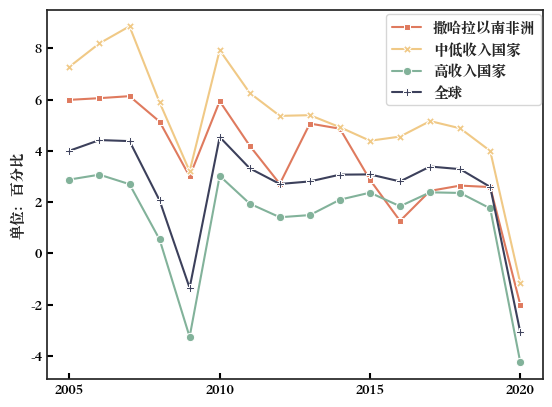

In [3]:
gdp_index = "GDP (constant 2015 US$)"
gdp_cn_names = {
    "GDP (constant 2015 US$)": "GDP（2015年不变价美元）",
    "GDP (current US$)": "GDP（现价美元）",
    "GDP, PPP (current international $)": "按购买力平价 (PPP) 衡量的 GDP（现价国际元）",
    "GDP, PPP (constant 2017 international $)": "按购买力平价 (PPP) 衡量的 GDP（2017不变价国际元）",
}
index_id = pd.DataFrame(wb.series.info().items).query("value == @gdp_index").iloc[0]["id"]
gdp = df_world.query("`Alpha-3 code` == 'SSA'")[["Year", gdp_index]]
gdp_2005 = gdp.query("Year == 2005").iloc[0, 1]
gdp_2020 = gdp.query("Year == 2020").iloc[0, 1]


thresholds = {
    "GDP (constant 2015 US$)": (5e10, "五百亿美元"),
    "GDP (current US$)": (5e10, "五百亿美元"),
    "GDP, PPP (constant 2017 international $)": (1e11, "千亿国际元"),
    "GDP, PPP (current international $)":  (1e11, "千亿国际元"),
}


def format_gdp(gdp, index):
    if gdp > 1e12:
        unit = "万亿"
        gdp/=1e12
    elif gdp > 1e8:
        unit = "亿"
        gdp/=1e8
    elif gdp > 1e4:
        unit = "万"
        gdp/=1e4
    else:
        unit = ""
    if index == "GDP (constant 2015 US$)":
        currency = "美元"
    elif index == "GDP (current US$)":
        currency = "美元"
    elif index == "GDP, PPP (current international $)":
        currency = "国际元"
    elif index == "GDP, PPP (constant 2017 international $)":
        currency = "国际元"
    else:
        currency = ""
    return f"{gdp:.2f}{unit}{currency}"


def economies_above_designated_size(index):
    threshold, _ = thresholds[index]
    df = wb.data.DataFrame(index_id, wb.region.members('SSF'), [2005, 2020])
    e2005 = df[df["YR2005"]>threshold].sort_values("YR2005", ascending=False).merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()
    e2020 = df[df["YR2020"]>threshold].sort_values("YR2020", ascending=False).merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()
    return e2005, e2020


e05, e20 = economies_above_designated_size(gdp_index)

def join_economies(economies):
    return "、".join(economies[:-1]) + "和" + economies[-1]

gdp_ssf = wb.data.DataFrame(index_id, {'SSF'} | wb.region.members("SSF"), [2005, 2020])
gdp_growth = ((gdp_ssf["YR2020"] / gdp_ssf["YR2005"]) ** (1 / 15) - 1)
gdp_ssf["GDP Growth"] = gdp_growth
gdp_growth_sff = gdp_growth.loc["SSF"]

high_gdp_growth_economics = gdp_ssf[gdp_growth > 0.05].sort_values("GDP Growth", ascending=False).merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()

document.add_heading("4.1.2  经济发展概况", 3)
document.add_paragraph("""整体来看，撒哈拉以南非洲经济基础薄弱且增速趋缓，工业化水平偏低，呈现资源型单一经济结构的特点，经济发展严重依赖自然资源。""")

plt.figure(figsize=(6.4, 4.8))
sns.set_palette(flatui)
ax = sns.lineplot(
    x="Year",
    y="GDP growth (annual %)",
    err_style=None,
    hue="Alpha-3 code",
    hue_order=abbreviation.keys(),
    style="Alpha-3 code",
    dashes=False,
    legend=False,
    markers=True,
    data=df_world,

)
ax.set(xticks=range(2005, 2021, 5), xlabel="", ylabel="单位：百分比")
ax.legend(abbreviation.values())
sns.move_legend(ax, "best", bbox_to_anchor=(0.67, 0.722), ncol=1, fontsize=10.5)
ax.tick_params(left=True, right=False, bottom=True, top=False, **common_tick_params)

ax.set_ylabel("单位：百分比", size=10.5)
fig_4_2 = BytesIO()
plt.savefig(fig_4_2, format="png", dpi=300, bbox_inches="tight")
document.add_picture(fig_4_2, width=docx.shared.Inches(6.4), height=docx.shared.Inches(4.8))
document.add_paragraph(f"""{time_period}年间，以{gdp_cn_names[gdp_index]}计，撒哈拉以南非洲GDP总额由{format_gdp(gdp_2005, gdp_index)}{"增加" if gdp_2020 > gdp_2005 else "减少"}至{format_gdp(gdp_2020, gdp_index)}，撒哈拉以南非洲GDP总量达{thresholds[gdp_index][1]}的国家从{len(e05)}个（{join_economies(e05)}）增至{len(e20)}个（{join_economies(e20)}）。多数国家GDP总量不足{thresholds[gdp_index][1]}，整体经济发展水平相对较低。从增速看， {time_period}年间撒哈拉以南非洲GDP年均增长率为{gdp_growth_sff:.2%}，除南苏丹于2011年建国，以及厄立特里亚缺乏数据，其余绝大多数撒哈拉以南非洲国家的年均GDP均呈现出正增长，仅赤道几内亚和苏丹负增长。其中，年均增长率超过5%的国家达{len(high_gdp_growth_economics)}个，分别为{join_economies(high_gdp_growth_economics)}。但年均增速整体受2008年全球金融危机、2015年大宗商品价格下跌、2019冠状病毒病疫情等的影响，促使撒哈拉以南非洲国家的经济增速呈波动下降趋势，从过去的高于全球、高于高收入国家的平均水平向低于全球平均水平转变。""")
document.add_paragraph(f"""而且，撒哈拉以南非洲经济发展严重依赖于自然资源的开发和出口。图4.3显示，尽管撒哈拉以南非洲在自然资源损耗占GNI百分比从{wb.data.get("NY.ADJ.DRES.GN.ZS", "SSF", 2005)["value"]:.2f}%下降至{wb.data.get("NY.ADJ.DRES.GN.ZS", "SSF", 2020)["value"]:.2f}%，呈波动下降趋势，但与其他类型经济体相比，其自然资源损耗占GNI百分比始终较高。""")

In [4]:
tab_4_1 = wb.data.DataFrame(["TX.VAL.FUEL.ZS.UN", "TX.VAL.MMTL.ZS.UN"], wb.region.members("SSF"), 2020).dropna().merge(countrycode, left_index=True, right_on="Alpha-3 code").rename(columns={"CountryName_CN": "国家名"}).set_index("国家名")[["TX.VAL.FUEL.ZS.UN", "TX.VAL.MMTL.ZS.UN"]].sum(axis=1).to_frame("燃料、矿石和金属出口占商品出口百分比")
tab_4_1["主要出口的自然资源"] = "石油"
tab_4_1.loc["赞比亚", "主要出口的自然资源"] = "铜、钴"
tab_4_1.loc["莫桑比克", "主要出口的自然资源"] = "矿物燃料、铝"
tab_4_1.loc["刚果（金）", "主要出口的自然资源"] = "钴、铜"
tab_4_1.loc["毛里塔尼亚", "主要出口的自然资源"] = "铁矿砂"
tab_4_1.loc["尼日尔", "主要出口的自然资源"] = "铀、黄金"
tab_4_1.loc["南非", "主要出口的自然资源"] = "铂金、黄金"
tab_4_1.loc["津巴布韦", "主要出口的自然资源"] = "黄金、铁合金"
tab_4_1.loc["加纳", "主要出口的自然资源"] = "黄金、石油产品"
tab_4_1.loc["纳米比亚", "主要出口的自然资源"] = "氧化铀、钻石、黄金"
tab_4_1.loc["马达加斯加", "主要出口的自然资源"] = "镍矿"
tab_4_1 = tab_4_1.sort_values("燃料、矿石和金属出口占商品出口百分比", ascending=False).iloc[:10].reset_index()

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = document.add_table(tab_4_1.shape[0]+1, tab_4_1.shape[1])

# add the header rows.
for j in range(tab_4_1.shape[-1]):
    t.cell(0,j).text = tab_4_1.columns[j]

# add the rest of the data frame
for i in range(tab_4_1.shape[0]):
    for j in range(tab_4_1.shape[-1]):
        if j == 1:
            t.cell(i+1,j).text = f"{tab_4_1.values[i,j]:.2f}%"
        else:
            t.cell(i+1,j).text = str(tab_4_1.values[i,j])

document.add_paragraph("表 4.1显示了2020年撒哈拉以南非洲部分国家燃料、矿石和金属出口占商品出口百分比，以及主要出口的自然资源种类。其中，安哥拉、尼日利亚和刚果（布）的商品出口中石油占75%以上份额；赞比亚、莫桑比克、刚果（金）、津巴布韦、毛里塔尼亚、南非、尼日尔等以矿物燃料、矿石、金属等出口为主。")

document.add_paragraph("撒哈拉以南非洲多数国家也高度依赖大宗农产品的出口，且产品单一，仅依赖一种或两种商品。如2019年贝宁棉花占总出口额的54.95%，科摩罗和埃塞俄比亚仅咖啡出口占总出口额的43.91%和38.05%，科特迪瓦有38.93%的出口是可可及相关制品（African Union，2020）。对单一自然资源的依赖使得撒哈拉以南非洲经济较为脆弱，常受到国际大宗商品价格波动的影响。")

In [5]:
wb.data.get("AG.LND.FRST.ZS", "SSF", 2020)

{'value': 26.252576191879,
 'series': 'AG.LND.FRST.ZS',
 'economy': 'SSF',
 'aggregate': True,
 'time': 'YR2020'}

In [6]:
import faostat
pop = wb.data.DataFrame("SP.POP.TOTL", wb.region.members("SSF"), [2005, 2020]).dropna()

countries_with_100_million = pop.loc[pop["YR2020"] > 1e8].sort_values("YR2020", ascending=False).merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()
countries_with_30_million = pop.loc[(pop["YR2020"] > 3e7) & (pop["YR2020"] < 1e8)].sort_values("YR2020", ascending=False).merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()
life_exp = wb.data.DataFrame(["SP.DYN.LE00.FE.IN", "SP.DYN.LE00.MA.IN", "SP.DYN.LE00.IN"], wb.region.members("SSF"), 2020)
low_life_exp_countries = life_exp.query("`SP.DYN.LE00.FE.IN` < 60 and `SP.DYN.LE00.FE.IN` < 60").sort_values("SP.DYN.LE00.IN").merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()

undernourished = faostat.get_data_df("FS", {"elements": [6120], "items": "21001"}).query("Area in ['Southern Africa', 'Western Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa'] and Year in ['2005', '2020']").astype({"Year": "int64", "Value": "float64"}).set_index(["Area", "Year"])
document.add_heading("4.1.3  社会发展概况", 3)
document.add_paragraph(f"""因经济基础薄弱和自然条件的制约，撒哈拉以南非洲社会发展水平整体偏低，呈现人口众多且增速较快，劳动力资源丰富，但又面临生活质量不高且堪忧的状态。据世界银行数据显示，{time_period}年间，撒哈拉以南非洲人口从{wb.data.get("SP.POP.TOTL", "SSF", 2005)["value"]/1e8:.2f}亿人增至{wb.data.get("SP.POP.TOTL", "SSF", 2020)["value"]/1e8:.2f}亿人。与其他类型经济体相比，撒哈拉以南非洲人口年均增速下降幅度较小，且年均增速最快。到2020年，人口过亿的国家有{join_economies(countries_with_100_million)}，{join_economies(countries_with_30_million)}等国的人口也处于较高水平。而且，撒哈拉以南非洲人口结构年轻化，由此带来的劳动力资源丰富。""")
document.add_paragraph(f"""然而，从人口寿命来看，撒哈拉以南非洲人均寿命普遍低于全球平均水平（2020年全球女性为{wb.data.get("SP.DYN.LE00.FE.IN", "WLD", 2020)["value"]:.2f}岁，男性为{wb.data.get("SP.DYN.LE00.MA.IN", "WLD", 2020)["value"]:.2f}岁）。图4.5显示，部分国家的男性和女性的人均寿命尚不足60岁，如{join_economies(low_life_exp_countries)}。造成撒哈拉以南非洲人均寿命较低的原因有很多，不仅包括了洪水、干旱、极端天气等自然灾害原因，还有频繁发生的战争、医疗匮乏、营养不良和饥荒，以及2019冠状病毒病疫情等。频繁的战争和地区冲突对撒哈拉以南非洲社会发展的影响不言而喻，且艾滋病、疟疾和肺结核已成为制约其经济发展社会进步的三大疾病。据世界卫生组织数据显示，2005年撒哈拉以南非洲约有258万人患有艾滋病，有320万人感染HIV病毒，有240万人死于艾滋病（WHO，2006）。2020年，尽管这些疾病的发病率有所下降，但部分撒哈拉以南非洲国家的艾滋病等患病率仍处于较高水平。另据联合国数据显示，营养不良发生率在撒哈拉以南非洲整体和多数地区都呈现出明显的下降趋势，但因总人口数量的增加，但因总人口数量的增加，仅2005-2020年间西非处于营养不良状态的人口数量由{undernourished.loc[("Western Africa", 2005), "Value"]*100:.0f}万增长到了{undernourished.loc[("Western Africa", 2020), "Value"]*100:.0f}万，东非从{undernourished.loc[("Eastern Africa", 2005), "Value"]*100:.0f}万增长到{undernourished.loc[("Eastern Africa", 2020), "Value"]/100:.3f}亿，中非从{undernourished.loc[("Middle Africa", 2005), "Value"]*100:.0f}万增长到{undernourished.loc[("Middle Africa", 2020), "Value"]*100:.0f}万，南非则从{undernourished.loc[("Southern Africa", 2005), "Value"]*100:.0f}万增加到{undernourished.loc[("Southern Africa", 2020), "Value"]*100:.0f}万。""")

In [15]:
pop = wb.data.DataFrame("SP.POP.TOTL", wb.region.members("SSF"), [2005, 2020]).dropna()


life_exp = wb.data.DataFrame(["SP.DYN.LE00.FE.IN", "SP.DYN.LE00.MA.IN", "SP.DYN.LE00.IN"], wb.region.members("SSF"), 2020)
low_life_exp_countries = life_exp.query("`SP.DYN.LE00.FE.IN` < 60 and `SP.DYN.LE00.FE.IN` < 60").sort_values("SP.DYN.LE00.IN").merge(countrycode, left_index=True, right_on="Alpha-3 code")["CountryName_CN"].tolist()

undernourished = faostat.get_data_df("FS", {"elements": [6120], "items": "21001"}).query("Area in ['Southern Africa', 'Western Africa', 'Eastern Africa', 'Middle Africa', 'Northern Africa'] and Year in ['2001', '2020']").astype({"Year": "int64", "Value": "float64"}).set_index(["Area", "Year"])


print(f"""然而，从人口寿命来看，撒哈拉以南非洲人均寿命普遍低于全球平均水平（2020年全球女性为{wb.data.get("SP.DYN.LE00.FE.IN", "WLD", 2020)["value"]:.2f}岁，男性为{wb.data.get("SP.DYN.LE00.MA.IN", "WLD", 2020)["value"]:.2f}岁）。图4.5显示，部分国家的男性和女性的人均寿命尚不足60岁，如{join_economies(low_life_exp_countries)}。造成撒哈拉以南非洲人均寿命较低的原因有很多，不仅包括了洪水、干旱、极端天气等自然灾害原因，还有频繁发生的战争、医疗匮乏、营养不良和饥荒，以及2019冠状病毒病疫情等。频繁的战争和地区冲突对撒哈拉以南非洲社会发展的影响不言而喻，且艾滋病、疟疾和肺结核已成为制约其经济发展社会进步的三大疾病。据世界卫生组织数据显示，2005年撒哈拉以南非洲约有258万人患有艾滋病，有320万人感染HIV病毒，有240万人死于艾滋病（WHO，2006）。2020年，尽管这些疾病的发病率有所下降，但部分撒哈拉以南非洲国家的艾滋病等患病率仍处于较高水平。另据联合国数据显示，营养不良发生率在撒哈拉以南非洲整体和多数地区都呈现出明显的下降趋势，但因总人口数量的增加，但因总人口数量的增加，仅2005-2020年间西非处于营养不良状态的人口数量由{undernourished.loc[("Western Africa", 2001), "Value"]*100:.0f}万增长到了{undernourished.loc[("Western Africa", 2020), "Value"]*100:.0f}万，东非从{undernourished.loc[("Eastern Africa", 2001), "Value"]*100:.0f}万增长到{undernourished.loc[("Eastern Africa", 2020), "Value"]/100:.3f}亿，中非从{undernourished.loc[("Middle Africa", 2001), "Value"]*100:.0f}万增长到{undernourished.loc[("Middle Africa", 2020), "Value"]*100:.0f}万，南非则从{undernourished.loc[("Southern Africa", 2001), "Value"]*100:.0f}万增加到{undernourished.loc[("Southern Africa", 2020), "Value"]*100:.0f}万。""")

然而，从人口寿命来看，撒哈拉以南非洲人均寿命普遍低于全球平均水平（2020年全球女性为74.86岁，男性为69.80岁）。图4.5显示，部分国家的男性和女性的人均寿命尚不足60岁，如乍得、尼日利亚、中非、莱索托、南苏丹、索马里和马里。造成撒哈拉以南非洲人均寿命较低的原因有很多，不仅包括了洪水、干旱、极端天气等自然灾害原因，还有频繁发生的战争、医疗匮乏、营养不良和饥荒，以及2019冠状病毒病疫情等。频繁的战争和地区冲突对撒哈拉以南非洲社会发展的影响不言而喻，且艾滋病、疟疾和肺结核已成为制约其经济发展社会进步的三大疾病。据世界卫生组织数据显示，2005年撒哈拉以南非洲约有258万人患有艾滋病，有320万人感染HIV病毒，有240万人死于艾滋病（WHO，2006）。2020年，尽管这些疾病的发病率有所下降，但部分撒哈拉以南非洲国家的艾滋病等患病率仍处于较高水平。另据联合国数据显示，营养不良发生率在撒哈拉以南非洲整体和多数地区都呈现出明显的下降趋势，但因总人口数量的增加，但因总人口数量的增加，仅2005-2020年间西非处于营养不良状态的人口数量由3600万增长到了5580万，东非从9850万增长到1.264亿，中非从3520万增长到5100万，南非则从290万增加到640万。


/Users/tcztzy/GitHub/han2023/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 32.125000000000014, '男性平均寿命')

<Figure size 640x480 with 0 Axes>

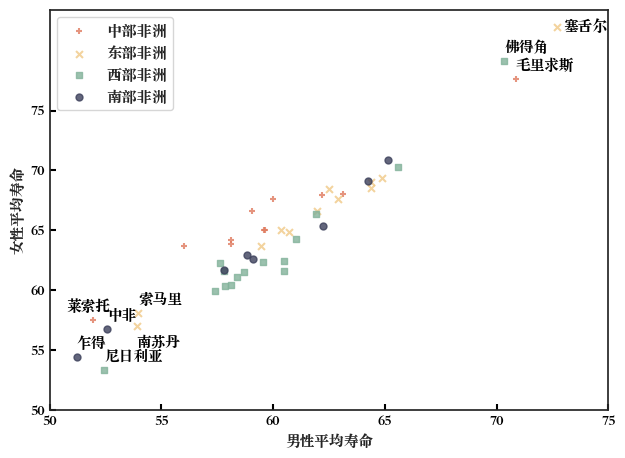

In [7]:
life_exp = wb.data.DataFrame(["SP.DYN.LE00.FE.IN", "SP.DYN.LE00.MA.IN", "SP.DYN.LE00.IN"], wb.region.members("SSF"), 2020)

data = life_exp.merge(countrycode, left_index=True, right_on="Alpha-3 code").merge(pd.read_excel(
    route
    / "Country Classification"
    / "UN Classification_Natural resources_Geography.xlsx",
    sheet_name="Sheet1",
    na_values="..",
    usecols="D, E, F, H",
), on="Numeric").set_index("CountryName_CN").query("Region != 'N'").rename(columns={"SP.DYN.LE00.FE.IN": "女性平均寿命", "SP.DYN.LE00.MA.IN": "男性平均寿命"})[["女性平均寿命", "男性平均寿命", "Region"]]
data["地区"] = data["Region"].str.translate(str.maketrans(africa_region))

plt.figure(figsize=(6.4, 4.8))
sns.set_palette(flatui)

ax = sns.lmplot(
    x="男性平均寿命",
    y="女性平均寿命",
    hue="地区",
    legend=False,
    markers=["+", "x", "s", "o"],
    fit_reg=False,
    scatter_kws={"s": 25},
    data=data,
    height=4.8,
    aspect=6.4 / 4.8,
)
sns.despine(top=False, right=False, left=False, bottom=False)
for z, r in data.iterrows():
    lem = r["男性平均寿命"]
    lef = r["女性平均寿命"]
    if lem > 67 or lem < 55:
        if z == "南苏丹":
            x = lem
            y = lef - 1.7
        elif z == "莱索托":
            x = lem - 1.2
            y = lef + 0.8
        elif z == "塞舌尔":
            x = lem + 0.3
            y = lef - 0.3
        else:
            x = lem
            y = lef + 0.8
        plt.text(
            x,
            y,
            z,
            horizontalalignment="left",
            size="medium",
            color="black",
            weight="semibold",
        )

plt.tick_params(
    left=True, bottom=True, **common_tick_params,
)
plt.legend(["中部非洲", "东部非洲", "西部非洲", "南部非洲"], loc="upper left")
plt.xticks(range(50, 80, 5))
plt.yticks(range(50, 80, 5))
plt.ylabel("女性平均寿命", size=10.5)
plt.xlabel("男性平均寿命", size=10.5)
#plt.savefig(life_exp_fig, bbox_inches="tight", dpi=300)
#document.add_picture(life_exp_fig, width=docx.shared.Inches(6.4), height=docx.shared.Inches(4.8))

In [8]:
document.add_paragraph(f"""撒哈拉以南非洲交通、水电能源等基础设施的建设也严重滞后，处于全球落后水平。仅以通电率来看，撒哈拉以南非洲在2005年至2020年期间有较大的增长，从{wb.data.get("EG.ELC.ACCS.ZS", "SSF", 2005)["value"]:.2f}%增长到{wb.data.get("EG.ELC.ACCS.ZS", "SSF", 2020)["value"]:.2f}%，仍远落后于世界平均水平。2020年，全球通电率平均值约为{wb.data.get("EG.ELC.ACCS.ZS", "WLD", 2020)["value"]:.2f}%，即便是中等和低收入国家也达到{wb.data.get("EG.ELC.ACCS.ZS", "LMY", 2020)["value"]:.2f}%。撒哈拉以南非洲地区有近6亿人无法用电，占全球无电人口的2/3以上。""")

In [9]:
document.add_heading("4.1.4  外商投资概况", 3)

document.add_paragraph("因矿产资源丰富和人口红利等的吸引，以及政局不稳定等的制约，撒哈拉以南非洲外商投资整体偏低，但呈现波动增长的态势，并在空间上从最初的以南部非洲为投资重点区域，逐渐向西非、中非和东非扩散。")

Africa = ['Other Africa', 'West Africa', 'East Africa', 'Central Africa', 'Southern Africa']

ssf_fdi_instock = pd.read_excel(route / "UNCTAD" / "wir2023_tab03.xlsx", skiprows=2, skipfooter=8).query("`Region/economy` in @Africa").melt(id_vars="Region/economy", var_name="Year", value_name="FDI instock").astype({"Year": "int64"}).set_index(["Region/economy", "Year"])["FDI instock"]
ssf_fdi_inflows = pd.read_excel(route / "UNCTAD" / "wir2023_tab01.xlsx", skiprows=2, skipfooter=8).query("`Region/economy` in @Africa").melt(id_vars="Region/economy", var_name="Year", value_name="FDI inflows").astype({"Year": "int64"}).set_index(["Region/economy", "Year"])["FDI inflows"]

document.add_paragraph(f"""{time_period}年间，撒哈拉以南非洲FDI流量占全球FDI流量的比重始终较低，在多数年份中占比不足2.5%，但FDI流量从{ssf_fdi_inflows.loc["Other Africa", 2005]/100:.2f}亿美元增至{ssf_fdi_inflows.loc["Other Africa", 2020]/100:.2f}亿美元，年均增长率达{(ssf_fdi_inflows.loc["Other Africa", 2020]/ssf_fdi_inflows.loc["Other Africa", 2005]) ** (1 / (2020 - 2005)) - 1:.2%}，投资的重点区域由南非和西非少量国家逐步扩展到东非、西非、南非和中非；FDI存量（不包括南苏丹）也呈现出增长的态势，从{ssf_fdi_instock.loc["Other Africa", 2005]/100:.2f}亿美元增至{ssf_fdi_instock.loc["Other Africa", 2020]/100:.2f}亿美元，年均增长率达{(ssf_fdi_instock.loc["Other Africa", 2020]/ssf_fdi_instock.loc["Other Africa", 2005]) ** (1 / (2020 - 2005)) - 1:.2%}，投资的重点区域从南非逐渐向西非、中非和东非扩散。到2020年，投资流量最多的地区依次为{join_economies(ssf_fdi_inflows.loc[['West Africa', 'East Africa', 'Central Africa', 'Southern Africa'], 2020].sort_values(ascending=False).index.get_level_values(0).str.replace("Central ", "中").str.replace("East ", "东").str.replace("West ", "西").str.replace("Southern ", "南").str.replace("Africa", "非"))}；投资存量最多的地区依次为{join_economies(ssf_fdi_instock.loc[['West Africa', 'East Africa', 'Central Africa', 'Southern Africa'], 2020].sort_values(ascending=False).index.get_level_values(0).str.replace("Central ", "中").str.replace("East ", "东").str.replace("West ", "西").str.replace("Southern ", "南").str.replace("Africa", "非"))}。""")

In [10]:
document.add_heading("4.1.5 环境发展概况")

document.add_paragraph("""撒哈拉以南非洲在经济发展的过程中，对环境也造成了不同程度的破坏，导致环境质量持续下降，污染问题日益严重。加之全球气候变化，给撒哈拉以南非洲脆弱的生态环境造成的影响巨大。""")

document.add_paragraph(f"""森林砍伐、土地退化、空气污染、水污染、生物多样性丧失等已经在撒哈拉以南非洲造成了难以挽回的影响。其中，最为突出的问题之一是撒哈拉以南非洲热带雨林被大量砍伐、森林面积缩小导致的降雨量减少、山洪、干旱、土壤侵蚀等。{time_period}年间，撒哈拉以南非洲森林面积占土地面积的百分比从30.69%下降至26.46%。由此带来的空气污染问题也日益严重。以PM2.5为例，撒哈拉以南非洲的PM2.5年均暴露量长期高于35微克/立方米，远高于世界卫生组织的标准，且呈明显增长的态势。再以CO2为例，撒哈拉以南非洲2005年至2020年二氧化碳排放量从{wb.data.get("EN.ATM.CO2E.KT", "SSF", 2005)["value"]/1e5:.2f}亿吨增长到{wb.data.get("EN.ATM.CO2E.KT", "SSF", 2020)["value"]/1e5:.2f}亿吨，因经济发展落后导致的排放量相对较小，但增速自2011年后超过了全球平均水平。据联合国环境署估计，2019年仅埃塞俄比亚因空气污染相关疾病造成的经济损失为30亿美元，占GDP的1.16%（UNEP，2021）。
""")

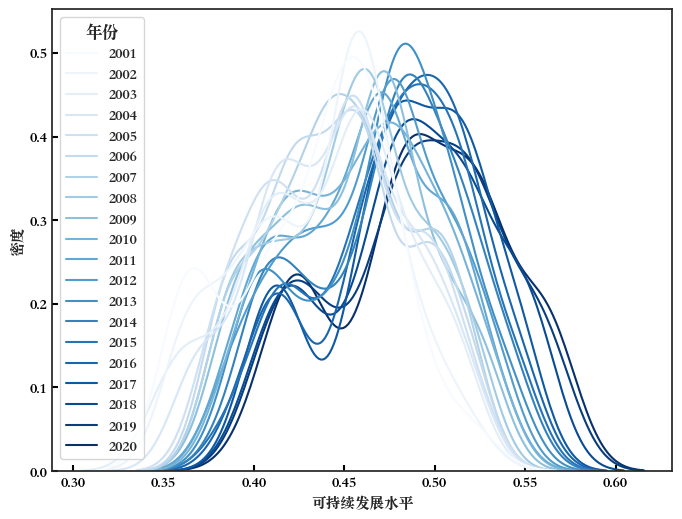

In [11]:
output = Path.home() / "OneDrive" / "PhD Dissertation" / "Pictures"

df = pd.read_excel(
    Path.home()
    / "OneDrive"
    / "PhD Dissertation"
    / "Data_Code"
    / "Data"
    / "index_data.xlsx",
    index_col=0,
).set_index(["Numeric", "Year"])

palette = sns.color_palette("Blues", as_cmap=True)

plt.figure(figsize=(8, 6))
data = df.rename_axis(index={'Year': '年份'})
ax = sns.kdeplot(data=data, x="SDI", hue="年份", bw_adjust=0.7, legend=True, palette=palette)
#plt.legend()
plt.tick_params(left=True, bottom=True, **common_tick_params)
plt.xlabel("可持续发展水平", size=10.5)
plt.ylabel("密度", size=10.5)
plt.savefig(output / "可持续发展指数密度图.png", bbox_inches="tight", dpi=300)

ValueError: Argument Z must be 2-dimensional.

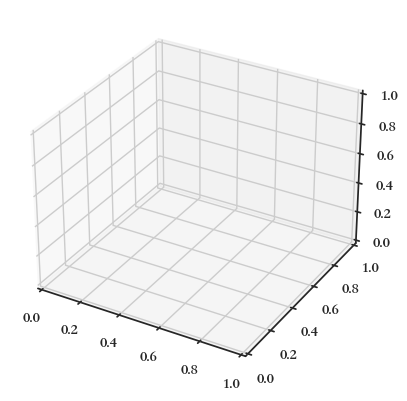

In [12]:
import numpy as np
from sklearn.neighbors import KernelDensity

data = df.query("Year>=2005&Year<=2020").dropna()
Z = []
grids = 20
for year, g in data.groupby(level=1):
    X = g[["SDI"]].to_numpy()
    kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(X)
    X_plot = np.linspace(0, 1, grids)[:, np.newaxis]
    Z.append(np.exp(kde.score_samples(X_plot)))
Y = data.index.get_level_values(1).unique().sort_values()
X = np.linspace(0, 1, grids)
X1, Y1 = np.meshgrid(X, Y)
Z1 = np.array(Z)
ax = plt.axes(projection='3d')
ax.plot_surface(X1, Y1, Z1, cmap=sns.color_palette("Blues", as_cmap=True))
ax.set_yticks(range(2005, 2021, 5))
ax.view_init(10, -60)

In [ ]:
SDI_growth = ((df.query("Year == 2020")["SDI"].droplevel(1) / df.query("Year == 2019")["SDI"].droplevel(1)) ** (1 / (2020 - 2005)) - 1).to_frame("SDI growth") * 10000

In [ ]:
document.add_heading("4.3.1 非洲可持续发展综合水平的时空演变轨迹")

SDI_growth = ((df.query("Year == 2020")["SDI"].droplevel(1) / df.query("Year == 2019")["SDI"].droplevel(1)) ** (1 / (2020 - 2005)) - 1).to_frame("SDI growth") * 10000

SDI_growth_ge_zero = SDI_growth.merge(countrycode.merge(pd.read_excel(Path.home() /"OneDrive"/"Rawdata"/"Country Classification"/"UN Classification_Natural resources_Geography.xlsx"), on=["Numeric", "Alpha-3 code", "WBCode"])[["Numeric", "CountryName_CN", "Region"]], left_index=True, right_on="Numeric").set_index("Numeric").query("`SDI growth` > 0").groupby("Region").count()["CountryName_CN"]

document.add_paragraph(f"""根据上述的测度方法，本文对非洲可持续发展综合水平的测度结果显示，{time_period}年间撒哈拉以南非洲{len(df["CountryName_CN"].unique())}个国家的可持续发展水平的综合得分均呈上升趋势。其中，截止至2019年均增速达1%以上的国家有17个（西非6个、东非6个、中非3个、南非2个）；年均增速处于0.5%至1%之间的国家共有14个（西非6个、东非5个、南非2个、中非1个）；年均增速低于0.5%的国家有2个，分别来自中非和东非。但是，到2020年，因新冠病毒病疫情的影响，撒哈拉以南非洲可持续发展综合水平的普遍下降，仅有{(SDI_growth > 0).sum()["SDI growth"]}个国家仍维持了正增长（西非{SDI_growth_ge_zero.loc["W"]}个、东非{SDI_growth_ge_zero.loc["E"]}个、南非{SDI_growth_ge_zero.loc["S"]}个、中非{SDI_growth_ge_zero.loc["C"]}个）。""")

document.add_paragraph(f"""为进一步揭示撒哈拉以南非洲{len(df["CountryName_CN"].unique())}个国家可持续发展水平随时间变化的趋势，采用核密度估计方法，以展示其可持续发展水平随时间分布的规律。本文的核密度图使用Python的seaborn.kdeplot绘制，其中bw_adjust参数选为0.7，以下同。图4.7显示，{time_period}年间撒哈拉以南非洲可持续发展水平的核密度图峰值逐次提高并向右移动，显示其整体可持续发展水平不断增加且最高值持续提高的趋势。""")

document.add_paragraph(f"""根据非洲{len(df["CountryName_CN"].unique())}个国家可持续发展综合得分，将可持续发展水平划分为高水平（>0.75）、较高水平（(0.65，0.75]）、中等水平（(0.55，0.65]）、较低水平（(0.45，0.55]）和低水平（≤0.45）五个区间，并选取2005年、2010年、2015年和2019年四个时间节点，以更好揭示撒哈拉以南非洲33个国家可持续发展水平的变化轨迹，以下同。2005-2019年间，低水平国家从2个下降至0个；较低收入水平的国家由23个下降到5个；处于中等水平国家由8个增加至23个；较高水平国家由0个增加到5个。图4.8显示，中等及以上可持续发展水平国家呈现由南部向东西部扩散的趋势，最终形成了南部非洲的可持续发展水平相对较高，而西部和东部国家在此期间增速较快，中部可持续发展水平一直较低且增速较慢的格局。""")

In [ ]:
document.save(Path.home() / "Desktop" / "Measurement and spatiotemporal variation trajectory of sustainable development level in Africa.docx")